In [121]:
from py_hd_wallet import wallet
import eel
import re
from urllib.request import Request, urlopen
import json
import hashlib

import scrypt

from constants import *
from web3 import Web3
import os 
from dotenv import load_dotenv
from eth_account import Account 
import subprocess
import json
from bit import Key, PrivateKey, PrivateKeyTestnet
from bit.crypto import ECPrivateKey
from bit.curve import Point
from bit.format import (
    bytes_to_wif, public_key_to_address, public_key_to_coords, wif_to_bytes
)
from bit.network import NetworkAPI, get_fee_cached, satoshi_to_currency_cached
from bit.network.meta import Unspent
#from bit.transaction import calc_txid, create_p2pkh_transaction, sanitize_tx_data
from web3.middleware import geth_poa_middleware


#eel.init('web') #This is the one launching the app


#Wallet Functions

#@eel.expose
def create_seed():
    seed = re.sub("[^\w]", " ",  wallet.generate_mnemonic()).split()
    count = 0
    seed_dict = {}
    for word in seed:
        count += 1
        word_count = "word" + str(count)
        seed_dict.update( {word_count : word} )
    return seed_dict

#@eel.expose
def get_wallets(seed):
    coins = ['BTC','BTG','BCH','LTC','DASH','DOGE','XRP','ZCASH','XLM']
    coin_purse = {}
    for coin in coins:
        w = wallet.create_wallet(network=coin, seed=seed, children=1)
        coin_purse.update({
            coin : {"address": w['address'],
                   "privatek": w["xprivate_key"],
                   "publick" : w["xpublic_key"],
                   "children": w["children"]
                   }
        })
    return coin_purse

#@eel.expose
def priv_key_to_account(coin, priv_key):
    
    if coin == "ETH":        return Account.privateKeyToAccount(priv_key)       
    elif coin == "btc-test": return PrivateKeyTestnet(priv_key)  
    elif coin == "BTC":      return PrivateKey(priv_key) 
    else:                    return "Not a supported coin"

    
def create_tx(coin, account, to, amount):
    """
    coin options: eth, btc-test.
    account: account containing all the info like private and public 
    key as well as address of a certain account. This must be obtained
    trough the method priv_key_to_account().
    to: address to transfer funds.
    amount: amount of the currency. Take into account that Ether must 
    be expressed in weis.
    """
    if coin == "ETH":
        gas_estimate = w3.eth.estimateGas(
            {
                "from": account.address,
                "to": to,
                "value": amount
            }
        )

        return {
            "from": account.address,
            "to": to,
            "value": amount,
            "gasPrice": w3.eth.gasPrice,
            "gas": gas_estimate,
            "nonce":w3.eth.getTransactionCount(account.address)
        }

    elif coin == "btc-test":
        return PrivateKeyTestnet.prepare_transaction(account.address, [(to, amount, BTC)])
    
    elif coin == "BTC":
        return PrivateKey.prepare_transaction(account.address, [(to, amount, BTC)])
    
    else:
        return "Not a supported coin"

#@eel.expose
def send_tx(coin, account, to, amount):
    """
    coin options: eth, btc-test.
    account: account containing all the info like private and public 
    key as well as address of a certain account. This must be obtained
    trough the method priv_key_to_account().
    to: address to transfer funds.
    amount: amount of the currency. Take into account that Ether must 
    be expressed in weis.
    """  
    tx = create_tx(coin, account, to, amount)
    signed_tx = account.sign_transaction(tx) #how to do this tho
    
    if coin == "ETH": 
        result = w3.eth.sendRawTransaction(signed_tx.rawTransaction)
        return result.hex()
    
    elif coin == "btc-test":
        result = NetworkAPI.broadcast_tx_testnet(signed_tx)
        return result
    
    elif coin == "BTC":
        result = NetworkAPI.broadcast_tx(signed_tx)
        return result
    
    else:
        return "Not a supported coin"
    

#@eel.expose
def get_balance(coin, account):
    
    if coin == "ETH": 
        return w3.eth.getBalance(account.address)
         
    
    elif coin == "btc-test" or coin == "btc":
        return account.get_balance("btc")
    
    else:
        return "Not a supported coin"

    
    
    
#Dashboard Functions

def read_json(url):
    request = Request(url)
    response = urlopen(request)
    data = response.read()
    url2 = json.loads(data)
    return url2

#@eel.expose
def get_prices(ticker_list = ['BTC','BTG','BCH','LTC','DASH','DOGE','XRP','ZEC','XLM']): 
    # Leaving this an argument instead of fixed string for flexibility, can be simpler/faster with fixed url input
    ticker_string=""
    for ticker in ticker_list:
        ticker_string += ticker+","
    url = f"https://min-api.cryptocompare.com/data/pricemulti?fsyms={ticker_string}&tsyms=USD"
    price_data = read_json(url)
    return price_data


# Password Functions

def hash_pass(pass_w):
    #return hashlib.sha256(bytes(pass_w, 'utf-8')).hexdigest() #Original
    return scrypt.encrypt(pass_w , 'Josh Eric Christian Oscar', maxtime=0.2)

#@eel.expose
def set_password(pass_w):
    file = open(".pwd", "w")
    file.write(hash_pass(pass_w))
    file.close()
    return True

#@eel.expose
def check_password(pass_w):
    file = open(".pwd", "r")
    """
    ######Original ######
    if file.read() == hash_pass(pass_w): 
    
        return 'True'
    else:
        return 'False' 
        """
    return scrypt.decrypt(file.read(),'Josh Eric Christian Oscar',maxtime=0.4) == pass_w


#eel.start('loginWindow.html', size=(1350, 750))

In [18]:
seed = create_seed()

In [19]:
seed

{'word1': 'ready',
 'word2': 'plastic',
 'word3': 'ethics',
 'word4': 'debate',
 'word5': 'absorb',
 'word6': 'gaze',
 'word7': 'join',
 'word8': 'series',
 'word9': 'latin',
 'word10': 'certain',
 'word11': 'worth',
 'word12': 'offer'}

In [21]:
real_seed = ""
real_seed = [real_seed + seed[x] for x in seed]
real_seed = " ".join(real_seed)
real_seed

'ready plastic ethics debate absorb gaze join series latin certain worth offer'

In [97]:
def derive_wallets(mnemonic, coin, nkeys):

    command = f'./hd-wallet-derive/hd-wallet-derive.php --mnemonic="{mnemonic}" --coin={coin} --numderive={nkeys}  --format=json -g'
    new_process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)

    (output, err) = new_process.communicate()

    p_status = new_process.wait()

    if err:
        print("\nError:###\n\n")
        return err

    return json.loads(output)
    #return output


coins = {
    "eth"     : derive_wallets(real_seed, "ETH", 10), 
    "btc-test": derive_wallets(real_seed, "BTC-test", 10),
    "btc"     : derive_wallets(real_seed, "BTC", 10)
}

In [108]:
coins["btc-test"]

[{'path': "m/44'/1'/0'/0/0",
  'address': 'mpChnAKRoQjSLFnQ68gCAnUoanYq4Kb4Hb',
  'xprv': 'tprv8kG39HxK9185SojyCMVhPXAS9SdBdn9Ho9rVZiR4kN7YNCVMHVfhQVZtpteJR3ntvDnp9Hq1qPDbJa2wpCwNveDoyseNb5N9rUgddXNpeH3',
  'xpub': 'tpubDGx5HhzZHNokLGmm61AHnvpYiU97o7LCNTTGrETNAduwCgk7utVHazBm13xE43wtWRCZwu8ztNmZNsdYecY7H3KPVK4Mq2BPraLVse9Dauq',
  'privkey': 'cRkadzWgsEm6fWtSSwk8bqVKpoL7UCnkTVd4gAagUtFJGF6sgeBS',
  'pubkey': '03b3929b199a9e20e87b1a67182cb3c0edad99ce2d6d49f37968994f8339d0305e',
  'pubkeyhash': '5f458724ce63c7d1dc92d1c69d9e84c4b5729255',
  'index': 0},
 {'path': "m/44'/1'/0'/0/1",
  'address': 'mnjmEBahguS742TYvRgBdQX3NJfhb5iHLQ',
  'xprv': 'tprv8kG39HxK9185WSWsfd3zxHWTo4k33zXujmtRACwupSj2CGw7QmmMfu6fVVEyLcUCF2LMREqPUzDhDVtrhxAPAaS7xbkgNahv7RPXdfHwFL4',
  'xpub': 'tpubDGx5HhzZHNokPuYfZGibMhAaN6FyDKipK5VCSizDEiXR2mBt3AawrPiXfb2b98tXTYWr9w5HDPGimLsDcp1tQnEzyvzuegsQFRGhYXQFfPy',
  'privkey': 'cTK8JkY64F3p6jHoWKFkpSPmQKXqhhQtbNcC4aSa3dUrhriprFJ1',
  'pubkey': '02123f6dbc5c51bb115dd2881a3ca676

In [91]:
import qrcode

In [115]:
img = qrcode.make(coins["btc-test"][0]["address"])

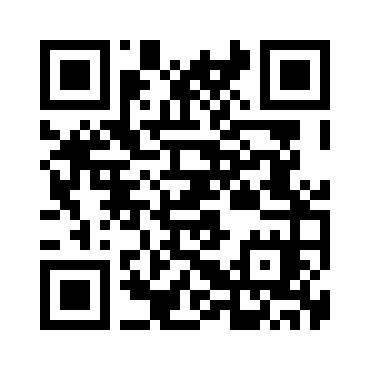

In [116]:
img

In [112]:
my_btctest_account = priv_key_to_account("btc-test",coins["btc-test"][0]["privkey"])
#my_btc_account = priv_key_to_account("BTC",privkey)

In [113]:
my_btctest_account

<PrivateKeyTestnet: mpChnAKRoQjSLFnQ68gCAnUoanYq4Kb4Hb>

In [114]:
my_btctest_account.address

'mpChnAKRoQjSLFnQ68gCAnUoanYq4Kb4Hb'

In [117]:
get_balance("btc-test", my_btctest_account)

'0.02'

In [122]:
send_tx(coin = "btc-test",account = my_btctest_account, to = coins["btc-test"][1]["address"],amount= 0.01)

In [119]:
 coins["btc-test"][1]["address"]

'mnjmEBahguS742TYvRgBdQX3NJfhb5iHLQ'

In [123]:
my_other_btctest_account = priv_key_to_account("btc-test",coins["btc-test"][1]["privkey"])

In [124]:
get_balance("btc-test", my_other_btctest_account)

'0.01'

In [125]:
get_balance("btc-test", my_btctest_account)

'0.00997008'